<a href="https://colab.research.google.com/github/16Komang/PCVK/blob/main/tubesPCVK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [12]:
# Menentukan path dataset pada Google Drive
dataset_path = '/content/drive/MyDrive/Images/Rice Leaf Disease'

In [13]:
# Menentukan dimensi input gambar dan jumlah kelas
input_shape = (224, 224, 3)
num_classes = 3

In [14]:
# Membuat objek ImageDataGenerator untuk augmentasi data
data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # membagi data menjadi training dan validation set
)

# Menggunakan ImageDataGenerator untuk memuat data pelatihan dan validasi
train_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [15]:
# Membangun model dengan MobileNetV2 sebagai base model
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Mengganti layer terakhir base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Menggabungkan base model dengan layer yang telah dimodifikasi
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan layer-layer pada base model agar tidak ikut dilatih
for layer in base_model.layers:
    layer.trainable = False

# Mengkompilasi model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Menyimpan model
model_path = '/content/drive/MyDrive/PCVK/Images/Rice Leaf Disease/path_to_trained_model.h5'
model.save(model_path)
print("Model saved at", model_path)

Epoch 1/10
3/3 [==============================] - 11s 3s/step - loss: 1.0271 - accuracy: 0.5521 - val_loss: 0.6487 - val_accuracy: 0.8333
Epoch 2/10
3/3 [==============================] - 7s 3s/step - loss: 0.4639 - accuracy: 0.7917 - val_loss: 0.4038 - val_accuracy: 0.8333
Epoch 3/10
3/3 [==============================] - 7s 3s/step - loss: 0.2856 - accuracy: 0.8958 - val_loss: 0.3682 - val_accuracy: 0.7917
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 0.1818 - accuracy: 0.9479 - val_loss: 0.3383 - val_accuracy: 0.9167
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 0.1213 - accuracy: 0.9583 - val_loss: 0.2431 - val_accuracy: 0.9167
Epoch 6/10
3/3 [==============================] - 7s 3s/step - loss: 0.0834 - accuracy: 0.9792 - val_loss: 0.3611 - val_accuracy: 0.8333
Epoch 7/10
3/3 [==============================] - 7s 3s/step - loss: 0.0864 - accuracy: 0.9583 - val_loss: 0.3623 - val_accuracy: 0.8750
Epoch 8/10
3/3 [========================

1/1 [==============================] - 0s 59ms/step
Predicted class: bacterial_leaf_blight


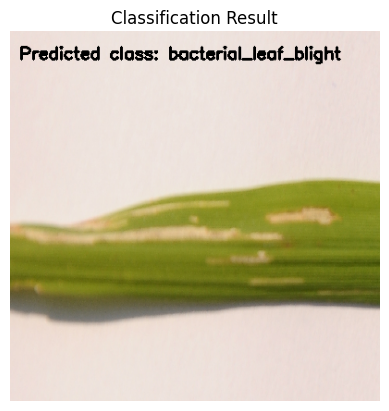

1/1 [==============================] - 0s 147ms/step
Predicted class: brown_spot


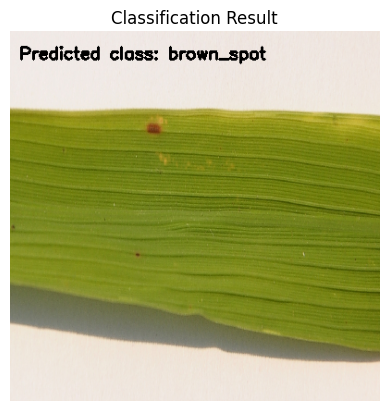

1/1 [==============================] - 0s 40ms/step
Predicted class: leaf_smut


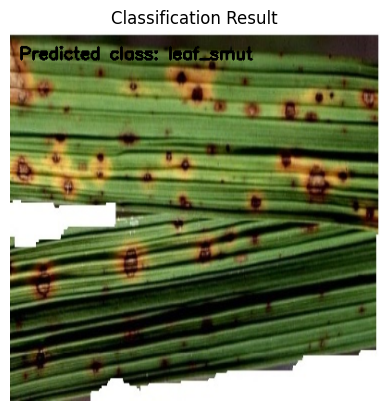

In [23]:
# Menampilkan hasil klasifikasi dengan output gambar
def show_classification(image_path, predicted_class):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengubah format warna gambar BGR menjadi RGB
    image = cv2.resize(image, (400, 400))
    cv2.putText(image, "Predicted class: " + predicted_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
    
    plt.imshow(image)
    plt.axis('off')
    plt.title("Classification Result")
    plt.show()

# Memuat beberapa gambar untuk diklasifikasikan
test_images = [
   '/content/drive/MyDrive/Images/Rice Leaf Disease/Bacterial leaf blight/DSC_0703.JPG',
    '/content/drive/MyDrive/Images/Rice Leaf Disease/Brown spot/DSC_0394.jpg',
    '/content/drive/MyDrive/Images/Rice Leaf Disease/Leaf smut/DSC_0516.jpg'
]

for image_path2 in test_images:
    image = cv2.imread(image_path2)
    image = cv2.resize(image, input_shape[:2])
    image = image.astype("float") / 255.0
    image = np.expand_dims(image, axis=0)

    # Melakukan klasifikasi gambar
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]

    # Menampilkan hasil klasifikasi
    print("Predicted class:", predicted_class)

    # Menampilkan output gambar
    show_classification(image_path2, predicted_class)